In [1]:
import numpy as np    
import matplotlib.pyplot as plt       
import torch                            
import torch.nn as nn               
import torch.optim as optim             
import torch.nn.functional as F         
import os                             
from PIL import Image   
import torchvision.transforms as transforms                     
import warnings                                           
warnings.filterwarnings('ignore')       

In [25]:
# Set random seed
import random
torch.backends.cudnn.deterministic = True       # Set random number generator in cudnn framework to deterministic mode
torch.backends.cudnn.benchmark = False          # Turn off the function of automatically finding the optimal convolution algorithm of the CuDNN framework to avoid the impact of different algorithms on the results.
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [26]:
def getPhoto(path_photo):
    files_list = os.listdir(path_photo) 
    return files_list

In [5]:
data=[]
label=[]

# The number on the hand is i
for i in range(10):
    path='./Sign-Language-Digits-Dataset/train/A'+str(i)+"/"
    list=getPhoto(path)
    
    for j in range(len(list)):
        full_path=path+list[j]
        data.append(full_path)
        label.append(i)
        
data=np.array(data)
label=np.array(label)

In [6]:
num=[i for i in range(len(data))]
np.random.shuffle(num)
data=data[num]
label=label[num]
train_X=np.array(data[:8*len(data)//10])
train_y=np.array(label[:8*len(data)//10])
test_X=np.array(data[8*len(data)//10:])
test_y=np.array(label[8*len(data)//10:])

In [7]:
np.sum(train_y==0),np.sum(train_y==1),np.sum(train_y==2),np.sum(train_y==3),np.sum(train_y==4),np.sum(train_y==5),np.sum(train_y==6),np.sum(train_y==7),np.sum(train_y==8),np.sum(train_y==9)

(140, 140, 138, 142, 138, 139, 136, 141, 126, 129)

In [8]:
# Define the standard of regularization, the mean and variance of the three color channels, which are values ​​derived from the ImageNet data set
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [9]:
# The values ​​of mean and variance are obtained from ImageNet
transform=transforms.Compose([
     transforms.RandomRotation(30), # Randomly rotate an angle within the range of [-30,30]
     transforms.RandomResizedCrop(size=100, scale=(0.8, 1.2),interpolation=transforms.functional.InterpolationMode.BILINEAR),# First, scale the image randomly, and then change the image into a 100*100 image.
     transforms.RandomHorizontalFlip(), # Random horizontal flip
     #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5), # Random color transformation
     transforms.ToTensor(), # Convert to tensor
     normalize # Standardized operations on images
])

In [10]:
X_train=[]
y_train=[]

for epoch in range(15):
    for i in range(len(train_X)):
        img=Image.open(train_X[i])
        img=np.array(transform(img))
        X_train.append(img)
        y_train.append(train_y[i])
        
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [11]:
X_test=[]
y_test=[]

for epoch in range(15):
    for i in range(len(test_X)):
        img=Image.open(test_X[i])
        img=np.array(transform(img))
        X_test.append(img)
        y_test.append(test_y[i])
        
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [12]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [13]:
class CNN(nn.Module):

    def __init__(self):
        
        super(CNN,self).__init__()
       
        self.conv=nn.Sequential(
        
        #3*100*100
        nn.Conv2d(3,16,3,1,0,bias=True),
        #32*98*98
        nn.MaxPool2d(2,2,0),
        #32*49*49
        nn.BatchNorm2d(16),
        nn.SiLU(),
        
        nn.Conv2d(16,32,3,1,0,bias=True),
        #32*47*47
        nn.MaxPool2d(2,2,(1,1)),
        nn.BatchNorm2d(32),
        nn.GELU(),
        
        nn.Conv2d(32,64,3,1,0,bias=True),
        nn.MaxPool2d(2,2,0),
        #64*11*11
        nn.BatchNorm2d(64),
        nn.Tanh(),
        
        )
       
        # Fully connected network layer, input 64*30*30, output the probability of 10 categories
        self.Linear=nn.Sequential(
            nn.Linear(64*11*11,1024),
            nn.GELU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024,124),
            nn.GELU(),
            nn.BatchNorm1d(124),
            nn.Linear(124,10),
        )
      
        
    def forward(self,input): 
        output=input
        output=self.conv(output)
        output=output.view(-1,64*11*11)
        output=self.Linear(output)

        return F.softmax(output,dim=1)

In [14]:
def weight_init(m):
    # Get the name of the class to which the object belongs
    class_name=m.__class__.__name__
    
    # When "conv" appears in the name of the object, it is a convolution operation
    if class_name.find('conv')!=-1:
        
        # The convolution kernel is randomly initialized according to the mean and standard deviation of the normal distribution. 
        m.weight.data.normal_(0,0.02)

In [15]:
# Initialize the neural network
netC=CNN()
netC.apply(weight_init)
print(netC)

# optimizer
optimizer=optim.Adam(netC.parameters(),lr=0.0002,betas=(0.5,0.999))

# loss function
criterion=nn.NLLLoss() # Negative log-likelihood loss function is also a type of cross-entropy loss function

# The training cycle is 10 times
num_epochs=10
errors=[]

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): SiLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): GELU(approximate='none')
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
  )
  (Linear): Sequential(
    (0): Linear(in_features=7744, out_features=1024, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_

In [16]:
for epoch in range(num_epochs):
    num=[i for i in range(len(X_train))]
    np.random.shuffle(num)
    X_train=X_train[num]
    y_train=y_train[num]
    print("start")
    
    for i in range(10):
        image=[]
        label=[]
        
        for j in range(500):
            image.append(X_train[1000*i+j].reshape((3,100,100)))
            label.append(y_train[1000*i+j])
            
        # Convert data into a tensor format that can be processed
        image=torch.Tensor(image) 
        label=torch.Tensor(label).long() 
        
        # train
        netC.train()
        
        # Put the data in for training
        output=netC(image) #.to(device)
        
        # Calculate the loss function each time
        error=criterion(output,label)
        
        # Backpropagation
        error.backward()
        
        # Optimizer performs optimization (gradient descent, error reduction)
        optimizer.step()
        
        # Clear the gradient
        optimizer.zero_grad()
        
        if i%5==0:
            print(epoch,error)
            errors.append(error)

start
0 tensor(-0.1034, grad_fn=<NllLossBackward0>)
0 tensor(-0.3941, grad_fn=<NllLossBackward0>)
start
1 tensor(-0.5109, grad_fn=<NllLossBackward0>)
1 tensor(-0.5816, grad_fn=<NllLossBackward0>)
start
2 tensor(-0.6313, grad_fn=<NllLossBackward0>)
2 tensor(-0.6985, grad_fn=<NllLossBackward0>)
start
3 tensor(-0.7290, grad_fn=<NllLossBackward0>)
3 tensor(-0.7573, grad_fn=<NllLossBackward0>)
start
4 tensor(-0.7968, grad_fn=<NllLossBackward0>)
4 tensor(-0.8212, grad_fn=<NllLossBackward0>)
start
5 tensor(-0.8393, grad_fn=<NllLossBackward0>)
5 tensor(-0.8509, grad_fn=<NllLossBackward0>)
start
6 tensor(-0.8460, grad_fn=<NllLossBackward0>)
6 tensor(-0.8834, grad_fn=<NllLossBackward0>)
start
7 tensor(-0.9001, grad_fn=<NllLossBackward0>)
7 tensor(-0.9118, grad_fn=<NllLossBackward0>)
start
8 tensor(-0.9185, grad_fn=<NllLossBackward0>)
8 tensor(-0.9189, grad_fn=<NllLossBackward0>)
start
9 tensor(-0.9245, grad_fn=<NllLossBackward0>)
9 tensor(-0.9418, grad_fn=<NllLossBackward0>)


In [18]:
pred_y=[]

for i in range(len(X_train)):
    netC.eval()
    
    with torch.no_grad():
        pred=netC(torch.Tensor(X_train[i].reshape((1,3,100,100))))[0]#.to(device)
        pred=np.argmax(pred.detach().cpu().numpy())
        pred_y.append(pred)
        
    if i%1000==0:
        print(i)
        
print("Test set accuracy:",np.sum(pred_y==y_train)/len(y_train),"The total number of training sets is:",len(y_train))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
Test set accuracy: 0.9819819819819819 The total number of training sets is: 20535


In [19]:
torch.save(netC,"sign_language.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


forecast result: 3 actual value: 3


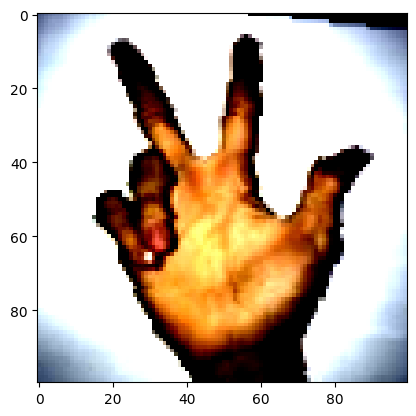

In [24]:
index=10
pred=netC(torch.Tensor(X_train[index].reshape(1,3,100,100)))[0]
print("forecast result:",np.argmax(pred.detach().cpu().numpy()),"actual value:",y_train[index])
plt.imshow(X_train[index].transpose(1,2,0))